In [36]:
##caricamento dati

import json
from datetime import datetime, timedelta

def aux(d):
    return {int(k): v for k,v in d.items()}

def loadData(directory='../transformData/'):
    date_format="%d/%m/%Y %H:%M"
    
    with open(directory + "mare_stop.json", 'r') as f:
        mare_stop = aux(json.load(f))
        
    with open(directory + "terra_stop.json", 'r') as f:
        terra_stop = aux(json.load(f))
    
    with open(directory + "stop_aggr.json", 'r') as f:
        stop_fun = aux(json.load(f))
        
    with open(directory + "stop_all.json", 'r') as f:
        stop = aux(json.load(f))
     
    with open(directory + "titoli.json", 'r') as f:
        titoli = aux(json.load(f))
    
    with open(directory + "validazioni.json", 'r') as f:
        validazioni = aux(json.load(f))
        val={}
        for k,v in validazioni.items(): #converte le date
            val[k]=[]
            for c in v:
                l=[(datetime.strptime(d,date_format), f) for d,f in c]
                val[k].append(l)
        
    return (titoli, val, mare_stop, terra_stop,stop_fun,stop)

titoli, validazioni, mare_stop, terra_stop,stop_fun,stop=loadData() 

In [37]:
#mare_stop

In [38]:
#corregge fermata errata e definisce funzione di mapping

stop[5138] = mare_stop[5138]
def f_title(f):
    return stop_fun.get(f,-1)

In [39]:
%%time

# seleziona utenti con titolo di durata 24 ore

t= [k for k,v in titoli.items() if v[1]==1]
user = []
for tit in t:
    user+=validazioni[tit]
print(len(user))

322732
CPU times: user 2.74 ms, sys: 1.19 ms, total: 3.93 ms
Wall time: 3.93 ms


In [41]:
#elimina fermate uguali consecutive, il parametro date fissa se mantere informazione della data o solo delle fermate

def clean_user(user, date = False):
    #eliminare fermate uguali consecutive
    if date:
        temp=[]
        for u in user:
            if len(u)>0:
                t = [u[0]]
                for d,f in u[1:]:
                    if f!=t[-1][1]:
                        t.append((d,f))
                t = tuple(t)
                temp.append(t)
            else:
                temp.append(())
        return temp
    else:
        temp=[]
        for u in user:
            if len(u)>0:
                t = [u[0]]
                for f in u[1:]:
                    if f!=t[-1]:
                        t.append(f)
                t = tuple(t)
                temp.append(t)
            else:
                temp.append(())
        return temp

In [42]:
# selezione utenti con 4 o 5 fermate
user = [ tuple([f_title(f) for d,f in u]) for u in user]
user = clean_user(user)
user = [u for u in user if len(u) in (4,5)]
len(user)

104808

In [43]:
# utenti distinti
user_reduce = list(set(user))
len(user_reduce)

30598

In [44]:
# salva vettore user per essere usato da programma c
def save_user(user):
    max_size = 5
    #with open("c/parte28/user_vect", "w") as f:
    with open("c/user_vect", "w") as f:
        for u in user:
            for j in u:
                f.write('%d\n' % j)
            for j in range(len(u), max_size):
                f.write("-9\n")
        
save_user(user_reduce)

FileNotFoundError: [Errno 2] No such file or directory: 'c/user_vect'

In [45]:
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
import numpy as np
from collections import Counter

In [46]:
#caricamento matrici calcolate in C e transformate con altro script python

#matrix=np.load("c/matrici/edit.npy")
#matrix = np.load("c/matrici/jaccard_subseq_3.npy")
matrix = np.load("c/matrici/lcs_balance.npy")
#matrix=np.load("c/matrici/lcs.npy")
#matrix = np.load("c/matrici/EDR.npy")

FileNotFoundError: [Errno 2] No such file or directory: 'c/matrici/lcs_balance.npy'

In [ ]:
matrix
#mat

array([[ 0, 23, 16, ..., 24, 23, 15],
       [23,  0, 16, ..., 24, 23, 16],
       [16, 16,  0, ..., 15, 15, 15],
       ...,
       [24, 24, 15, ...,  0, 24, 15],
       [23, 23, 15, ..., 24,  0, 15],
       [15, 16, 15, ..., 15, 15,  0]], dtype=uint8)

In [47]:
%%time
y = AgglomerativeClustering(affinity='precomputed', n_clusters=1250,
                            linkage='complete').fit_predict(matrix)

NameError: name 'matrix' is not defined

In [50]:
print(len(y))
y

NameError: name 'y' is not defined

In [48]:
# ricerca cluster che soddisfino 3 condizioni, numero utenti minimo, numero minimo di tratte percorse da almeno level degli utenti
def find_useful_cluster(user, user_reduce, y, level = 0.7, min_user = 200, min_tratte=2):
    all_c = set(y)
    user_dict = Counter(user)
    ris = []
    for c in all_c:
        user_c = [u for i,u in enumerate(user_reduce) if y[i]==c and y[i]!=-1]
        n_user= sum([ user_dict[u] for u in user_c])
        retry=False
        if n_user>=min_user:
            tratte_dict={}
            for u in user_c:
                for i,f in enumerate(u[:-1]):
                    temp = (f,u[i+1])
                    tratte_dict[temp] = tratte_dict.get(temp,0) + user_dict[u]
            tratte = tuple([k for k,v in tratte_dict.items() if v >= n_user*level])
            #rp = find_rappresentante(c, user, user_reduce, y, matrix)
            if len(tratte)>=min_tratte:
                ris.append((c, n_user, tratte))#, rp))            
            #elif len([ 1 for u in user_c if user_dict[u]>=min_user])>0:
                #evita che un cluster già esistente scompaia
                #ris.append((c, n_user, [ u for u in user_c if user_dict[u]>=min_user][0], rp))
    return ris

In [49]:
%%time
ris = find_useful_cluster(user, user_reduce, y, level=0.6)

NameError: name 'y' is not defined

In [ ]:
ris

[(7, 2953, ((5063, 5068), (5068, 5063))),
 (27, 2916, ((5032, 5063), (5063, 5068))),
 (51, 310, ((-1, 15060), (15060, 5068))),
 (67, 309, ((5032, 5063), (5063, 5068))),
 (141, 235, ((5032, 5038), (5038, -1))),
 (208, 310, ((15060, 5063), (5063, 5038))),
 (266, 416, ((15060, 5063), (5063, 5009))),
 (295, 219, ((5032, 5063), (5063, 15060))),
 (296, 235, ((5009, 5032), (5032, 5009))),
 (327, 4264, ((15060, 5063), (5063, 5068))),
 (328, 320, ((15060, 5097), (5097, 5068), (5068, 5063))),
 (331, 502, ((5501, 5038), (5038, 5501))),
 (355, 272, ((5001, 5068), (5068, 5063))),
 (398, 238, ((5009, 15108), (15108, 5009))),
 (460, 206, ((5009, 5068), (5032, 5009))),
 (488, 460, ((15060, 5068), (5068, 5038))),
 (501, 357, ((15108, 5068), (5068, 5063), (5063, 5068))),
 (516, 306, ((15060, 5063), (5063, 15060))),
 (532, 1089, ((5009, 5063), (5063, 5009))),
 (547, 729, ((5063, 5068), (5068, 5001))),
 (549, 350, ((5038, 5009), (5009, 5063))),
 (558, 344, ((5038, 5032), (5032, 5063))),
 (567, 222, ((5038

In [ ]:
print(len(ris))
sum([r[1] for r in ris])

66


47131

In [51]:
stat=[]
prex = 'c/matrici/'
matrix_name = ('edit.npy','jaccard_subseq_3.npy', 'lcs_balance.npy', 'lcs.npy', 'EDR.npy' )
for m in matrix_name:
    mat = np.load(prex + m)
    print(m)
    temp = [m]
    for n in (250,500,750,1000,1250, 1500, 1750, 2000):
        y = AgglomerativeClustering(affinity='precomputed', n_clusters=n,linkage='complete').fit_predict(mat)    
        ris = find_useful_cluster(user, user_reduce, y, level=0.6)
        temp.append((n, len(ris), sum([r[1] for r in ris])))
    stat.append(temp)
    print(temp)
print(stat)

FileNotFoundError: [Errno 2] No such file or directory: 'c/matrici/edit.npy'

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
print(np.load('c/matrici/jaccard_subseq_3.npy'))
#print(np.load('c/matrici/lcs.npy'))

[[0 3 4 ... 4 3 3]
 [3 0 4 ... 4 3 4]
 [4 4 0 ... 3 3 3]
 ...
 [4 4 3 ... 0 4 3]
 [3 3 3 ... 4 0 3]
 [3 4 3 ... 3 3 0]]


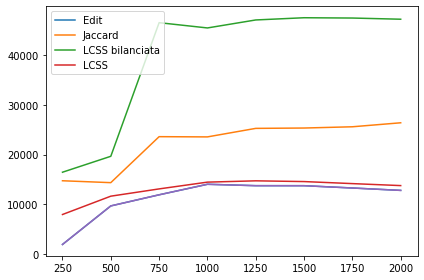

In [ ]:
y = (250,500, 750,1000,1250,1500,1750,2000)
fig, ax = plt.subplots(tight_layout=True)

for s in stat:
    t = [x[2] for x in s[1:] ]
    
    ax.plot(y,t, ms=10)

#ax.legend(['Edit', 'Jaccard', 'LCSS bilanciata', 'LCSS', 'EDR'], loc='upper left')
ax.legend(['Edit', 'Jaccard', 'LCSS bilanciata', 'LCSS'], loc='upper left')
#fig

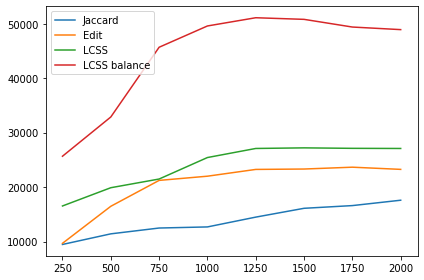

In [ ]:
# risultati celle precendi per non ricalcolare tutto

y = (250,500, 750,1000,1250,1500,1750,2000)
jaccard = [9460, 11410, 12479, 12681, 14482, 16102, 16599, 17586]
edit = [9668, 16471, 21226, 21998, 23242, 23314, 23652, 23251]

lcss = [16529, 19882, 21479, 25425, 27091, 27202, 27115, 27091]
lcss_balance = [25665, 32873, 45680, 49589, 51101, 50804, 49392, 48918]

fig, ax = plt.subplots(tight_layout=True)

ax.plot(y,jaccard, ms=10)
ax.plot(y,edit)
ax.plot(y,lcss)
ax.plot(y,lcss_balance)



ax.legend(['Jaccard', 'Edit', 'LCSS', 'LCSS balance'], loc='upper left')
#fig

In [ ]:
# restituisce rappresentante del cluster id_, il rappresentate è una tupla composta dalla fermate
# Il rappresentante appartiene agli utenti, ed è l'utente del cluster più vicino agli altri
# id_ corrisponde al cluster assegnato dall'algoritmo
# user e user_reduce sono le liste degli utenti
# y è il vettore risultato dell'algoritmo di cluster
# mat è la matrice precomputata di distanza
def find_rappresentante(id_, user, user_reduce, y, mat):
    user_dict = Counter(user)
    #print('user_dict')
    user_c = {i:u for i,u in enumerate(user_reduce) if y[i]==id_}
    
    #print('user_c')
    ris = []
    for i,u in user_c.items():
        acc=0
        for j,v in user_c.items():
            acc+=mat[i][j]*user_dict[v]
        ris.append((acc,u))
    ris.sort()
    return ris[0][1] if len(ris)>0 else ()

In [ ]:
#matrix

In [ ]:
#rappresentante = find_rappresentante(1214, user, user_reduce, y, matrix)

In [ ]:
def lcs(user, rap, m=0,n=0):
    if len(user)==m or len(rap)==n:
        return []
    elif user[m]==rap[n]:
        r = lcs(user, rap, m+1, n+1)
        return [(user[m], m,n )] + r
    else:
        a = lcs(user, rap, m, n+1)
        b = lcs(user, rap, m+1, n)
        return a if len(a)>len(b) else b
        

# dato il rappresentante di fin_rappresentante, filtra le fermate usando solo quelle validate da almeno level degli utenti del cluster
def get_rappresentante(id_, user, user_reduce, y, mat, level=0.7):
    rap = find_rappresentante(id_, user, user_reduce, y, mat)   
    #print(rap)
    user_dict = Counter(user)
    #print(user_dict)
    user_c = [u for i,u in enumerate(user_reduce) if y[i]==id_]
    dim = sum([user_dict[u] for u in user_c])
    
    freq= np.zeros(len(rap), dtype='int')
    for u in user_c:
        temp = lcs(u, rap)
        for f,m,n in temp:
            freq[n]+=user_dict[u]
    ris=[]
    for i,f in enumerate(rap):
        if freq[i]>dim*level:
            ris.append(f)

    return tuple(ris)
        

In [ ]:
# restituisce dettagli cluster, restituisce tratte e numero di utenti che le hanno percorse
# levelR è il livello per la chiamata a getRappresentante
# level è la percentuale di utenti del cluster che devono aver percorso la tratta
def get_cluster_detail(id_, user, user_reduce, y, mat, levelR=0.5, level = 0.5):
    rappresentante = get_rappresentante(id_, user, user_reduce, y, mat, level=levelR)
    print(rappresentante)
    user_c = [u for i,u in enumerate(user_reduce) if y[i]==id_ ] 
    user_dict=Counter(user)
    
    n_user = sum([v for k,v in user_dict.items() if k in user_c])
    print(n_user)
    
    tratte = {}
    for u in user_c:
        for i,f in enumerate(u[:-1]):
            temp = (f, u[i+1])
            tratte[temp] = tratte.get(temp, 0) + user_dict[u]
            
    print(len([k for k,v in tratte.items() if v>n_user*level]))
    return [(k,v) for k,v in tratte.items() if v>n_user*level]

In [ ]:
temp = get_cluster_detail(1214, user, user_reduce, y, matrix, level=0.05)

(5009, 5022)
18
13


In [ ]:
temp

[((5053, -1), 7),
 ((-1, 5009), 11),
 ((5009, 5049), 1),
 ((5009, 5022), 14),
 ((5022, 5049), 2),
 ((5063, 5053), 3),
 ((5022, 5038), 9),
 ((5038, 5138), 2),
 ((5038, 5032), 5),
 ((5032, 5053), 1),
 ((5038, 5049), 2),
 ((5022, 5051), 2),
 ((5051, -2), 2)]

In [ ]:
import os
import gmaps

gmaps.configure(api_key='')
# settare con chiave di google maps api

In [ ]:
# disegna cluster sulla mappa di google
def draw_cluster(id_, user, user_reduce, y, mat, level=0.5):
    fig = gmaps.figure(center=(45.433395, 12.344964), zoom_level=12, map_type='SATELLITE')
    rap = find_rappresentante(id_, user, user_reduce, y, mat)
    rappresentante = get_rappresentante(id_, user, user_reduce, y, mat, level=level)
    #rappresentante = find_rappresentante(id_, user, user_reduce, y, mat)
            
    user_c = [u for i,u in enumerate(user_reduce) if y[i]==id_ ] 
    user_dict=Counter(user)   
    
    n_user = sum([v for k,v in user_dict.items() if k in user_c])
    
    print("Dimensione rappresentanti:", len(user_c))  
    print("Dimensione cluster:", n_user)
    print(rappresentante)
    print(rap)
    for i,f in enumerate(rappresentante):
        print(i, '-', stop[f][0])
    
    
    
    linee=[]    
    invalid_linee=set()
    for i,f in enumerate(rappresentante[:-1]): 
        temp = tuple([tuple([float(z) for z in stop[f][1:]]),
                tuple([float(z) for z in stop[rappresentante[i+1]][1:]])])
        invalid_linee.add(temp)
        linee.append(temp)            
            
    lines=[]
    for (s,e) in linee:
        temp=gmaps.Line(
                    start=s,
                    end=e,
                    stroke_weight=2,
                    stroke_color='blue')
        lines.append(temp)    
        
    linee={}
    for u in user_c:
        for i,f in enumerate(u[:-1]):
            temp = tuple([tuple([float(z) for z in stop[f][1:]]),
                tuple([float(z) for z in stop[u[i+1]][1:]])])
            if temp not in invalid_linee and temp[::-1] not in invalid_linee:
                linee[temp] = linee.get(temp, 0) + user_dict[u] 
    
    for (s,e), v in linee.items():
        if v > n_user * 0.05:
            temp=gmaps.Line(
                        start=s,
                        end=e,
                        stroke_weight=1, # * v/n_user,
                        stroke_color='yellow')
            lines.append(temp)    
        
    drawing = gmaps.drawing_layer(features=lines)   
    
    
    #mappa di calore
    stop_c ={}
    for u in user_c:
        for f in u:
            stop_c[f]=stop_c.get(f,0)+ user_dict[u]           
    
    coord = [tuple([float(z) for z in stop[f][1:]]) for f in stop_c]
    weights = stop_c.values()
    
    heatmap_layer = gmaps.heatmap_layer(
        coord, weights = weights,
        max_intensity=n_user*level, point_radius=10.0)    
    
    fig.add_layer(heatmap_layer)    
    fig.add_layer(drawing)
    return fig

In [ ]:
#draw_cluster(1297, user, user_reduce, y, matrix, level=0.6)

In [ ]:
# verifica se cluster diversi hanno lo stesso rappresentante
def aggregate_cluster(user, user_reduce, y, matrix, level=0.6):
    all_c = set(y)
    user_dict = Counter(user)
    ris = {}
    for c in all_c:
        user_c = [u for i,u in enumerate(user_reduce) if y[i]==c and y[i]!=-1]
        n_user= sum([ user_dict[u] for u in user_c])
        rap = get_rappresentante(c, user, user_reduce, y, matrix, level=level)
        clusted_id, cluster_user = ris.get(rap,([],0))
        ris[rap]=(clusted_id+[c],cluster_user+n_user)
    return ris
        

In [ ]:
y

array([ 636,  687,  543, ...,  579, 1157,  407])

In [ ]:
aggregati = aggregate_cluster(user, user_reduce, y, matrix, level=0.6)
aggregati

{(5063, 5068): ([0], 502),
 (5063, 5009): ([1, 21], 101),
 (5001, 15108, 5068): ([2], 115),
 (5019, 5063): ([3], 69),
 (5116, 5063): ([4], 30),
 (5501, 5063): ([5, 149], 117),
 (15060, 5063, 5101): ([6], 31),
 (5063, 5068, 5063): ([7], 2953),
 (5063, 5004): ([8], 59),
 (5049, 5009): ([9], 99),
 (5037, 5053): ([10], 53),
 (5084, 5063): ([11, 351], 80),
 (5001, 5009, 5501): ([12], 77),
 (): ([13, 186, 499, 526], 82),
 (-1, 5501): ([14], 1036),
 (5501, 5053, 5501): ([15], 50),
 (5501, -1, 5138): ([16], 14),
 (5004, 5009, 5004): ([17, 23], 120),
 (5038, -1): ([18, 249], 247),
 (5501, 5032): ([19], 63),
 (5001, 5053): ([20], 48),
 (5004, 5001): ([22, 1009], 52),
 (-1, 5032): ([24, 164], 89),
 (15060, 5068, -1): ([25], 101),
 (5038, 5052): ([26], 86),
 (5032, 5063, 5068): ([27, 67], 3225),
 (5501, 5006): ([28], 19),
 (-1, 5063, 5062): ([29], 22),
 (5052, 5038): ([30], 56),
 (5053, 5008): ([31], 107),
 (-1, 5053): ([32, 275], 142),
 (5053, 5036): ([33], 60),
 (5501, 5068): ([34, 1065], 149),


In [ ]:
def get_cluster_list(user, user_reduce, y, mat, level=0.6):
    ris= []
    user_dict=Counter(user)   
    for id_ in set(y):
        rappresentante = get_rappresentante(id_, user, user_reduce, y, mat, level=level)
        user_c = [u for i,u in enumerate(user_reduce) if y[i]==id_ ] 
        n_user = sum([v for k,v in user_dict.items() if k in user_c])
        ris.append((n_user,rappresentante, id_))
        #print(id_)
    ris.sort(reverse=True)
    #ris.sort()
    ris = [(i,r,n) for n,r,i in ris]
    return ris
    

In [ ]:
%%time
new_y = y #aggiunto
cluster_list = get_cluster_list(user, user_reduce, new_y, matrix)
print(len(cluster_list))

1250
CPU times: user 1min 2s, sys: 28 ms, total: 1min 2s
Wall time: 1min 2s


In [ ]:
cluster_list

[(327, (15060, 5063, 5068), 4264),
 (638, (5063, 5068, 15060), 3201),
 (7, (5063, 5068, 5063), 2953),
 (27, (5032, 5063, 5068), 2916),
 (590, (5501, 5063, 5068), 2616),
 (362, (5009, 5021), 2444),
 (282, (5501, 5009), 2107),
 (1073, (15060, 5068, 5063), 2039),
 (662, (5063, 5068, 5038), 2011),
 (607, (5009, 5063, 5068), 1861),
 (664, (5009, 5063, 5068, 5009), 1593),
 (671, (5068, 5063, 5009), 1575),
 (797, (5032, 15060, 5068), 1242),
 (578, (5032, 5009, 5063), 1189),
 (532, (5009, 5063, 5009), 1089),
 (96, (15060, 5063), 1088),
 (14, (-1, 5501), 1036),
 (547, (5063, 5068, 5001), 729),
 (730, (5063, 5097, 5068), 686),
 (1192, (15060, 5068, 15060), 655),
 (389, (-1, 5001), 617),
 (620, (-1, 5501, 5063, 5068), 616),
 (1199, (5063, 5068, 5097), 588),
 (636, (5009, 5068, 5063), 587),
 (691, (5063, 5068, 5037), 545),
 (127, (5021, 5009), 520),
 (331, (5501, 5038, 5501), 502),
 (0, (5063, 5068), 502),
 (759, (5032, 5038, 5032), 495),
 (488, (15060, 5068, 5038), 460),
 (49, (5032, 5001), 450),

In [ ]:
%%time
ris = find_useful_cluster(user, user_reduce, y, level=0.6)
#ris = find_useful_cluster(user, user_reduce, y, level=0, min_user=0, min_tratte=0)

CPU times: user 4.76 s, sys: 3.19 ms, total: 4.76 s
Wall time: 4.76 s


In [ ]:
temp =[get_rappresentante(r[0], user, user_reduce, y, matrix, level=0.6) for r in ris]
print(len(temp), len(set(temp)))
#Counter(temp)


66 65


In [ ]:
temp_ris=[ (b,a,c) for a,b,c in ris]
temp_ris.sort(reverse=True)
print("Numero cluster:", len(temp_ris))
cluster_list = []
for n_user, id_, coppie in temp_ris:
    rap = tuple([stop[f][0] for f in get_rappresentante(id_, user, user_reduce, y, matrix, level=0.6)])
    print('id:', id_, 'n_user:', n_user, rap)
    cluster_list.append((id_, n_user, rap))

Numero cluster: 66
id: 327 n_user: 4264 ('f.te nove', 'murano', 'burano')
id: 638 n_user: 3201 ('murano', 'burano', 'f.te nove')
id: 7 n_user: 2953 ('murano', 'burano', 'murano')
id: 27 n_user: 2916 ('ferrovia', 'murano', 'burano')
id: 590 n_user: 2616 ('p.le roma', 'murano', 'burano')
id: 1073 n_user: 2039 ('f.te nove', 'burano', 'murano')
id: 662 n_user: 2011 ('murano', 'burano', 'rialto')
id: 607 n_user: 1861 ('s. zaccaria', 'murano', 'burano')
id: 664 n_user: 1593 ('s. zaccaria', 'murano', 'burano', 's. zaccaria')
id: 671 n_user: 1575 ('burano', 'murano', 's. zaccaria')
id: 797 n_user: 1242 ('ferrovia', 'f.te nove', 'burano')
id: 578 n_user: 1189 ('ferrovia', 's. zaccaria', 'murano')
id: 532 n_user: 1089 ('s. zaccaria', 'murano', 's. zaccaria')
id: 547 n_user: 729 ('murano', 'burano', 'lido')
id: 730 n_user: 686 ('murano', 'torcello', 'burano')
id: 1192 n_user: 655 ('f.te nove', 'burano', 'f.te nove')
id: 620 n_user: 616 ('TERRA', 'p.le roma', 'murano', 'burano')
id: 1199 n_user: 5

In [ ]:
cluster_list[0]

(327, (15060, 5063, 5068), 4264)

In [ ]:
###### fasce orarie #####

In [ ]:
fasce = np.array([(0,0), (6,0), (10,15), (12,0), (14,0), (15,45),(17,45), (20,0), (23,59)])

# restituisce la fascia oraria data una data
def hour_step(d):
    m = d.hour*60+d.minute
    f = fasce[:,0]*60+ fasce[:,1]
    return len(f) - (f>=m).sum()

In [ ]:
# dato un utente e un rappresentante crea il vettore che lo rappresenta. Il vettore ha dimensione pari al rappresentante
def get_user_time_vect(user, rap):
    ris=np.zeros(len(rap), dtype='i2')-1
    f_list=[f for d,f in user]
    seq = lcs(f_list, rap)
    
    for f,m,n in seq:
        ris[n]=hour_step(user[m][0])
        #d=user[m][0]
        #ris[n]= d.hour*60+d.minute
        
    #punto critico!!!! #avviene quando user non ha fatto tutte le fermate del rappresentante
    for i in range(len(rap)):
        if ris[i]==-1:
            if i==0:
                temp=-1
                j=0
                while temp == -1 and j<len(rap)-1:
                    temp=ris[j+1]
                    j+=1
                ris[i]=temp
            else:
                ris[i]=ris[i-1]    
   
    return ris
    

In [ ]:
id_

460

In [ ]:
# restituisce lista dei vettori di ciascun utente del cluster
def get_cluster_time_vect(id_, all_user,user,  user_reduce,y, mat, level=0.6):
    rap = get_rappresentante(id_, user, user_reduce, y, matrix, level=0.6)
    print(rap)
    user_c = set([u for i,u in enumerate(user_reduce) if y[i]==id_])
        
    temp = [ tuple([(d,f_title(f)) for d,f in u]) for u in all_user]
    temp = clean_user(temp, True)
    temp = [u for u in temp if len(u) in (4,5)]
    
    print(len(temp))
    
    all_u=[]
                   
    for u in temp:
        a = tuple([b[1] for b in u])
        if a in user_c:
            all_u.append(u)
            
    print(len(all_u))
            
    vet = np.zeros((len(all_u), len(rap)), dtype = 'i2')
    
    index =0 
    for u in all_u:
        vet[index]=get_user_time_vect(u, rap)
        index+=1
            
    return vet
        
    

In [ ]:
t= [k for k,v in titoli.items() if v[1]==1]
all_user = []
for tit in t:
    all_user+=validazioni[tit]

In [ ]:
%%time
cont=0
x = get_cluster_time_vect(34, all_user,user, user_reduce, new_y, matrix)
print(cont)

(5501, 5068)
104808
129
0
CPU times: user 874 ms, sys: 14.5 ms, total: 889 ms
Wall time: 887 ms


In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [ ]:
kmeans = KMeans(n_clusters=5, random_state=0).fit(x)
time_y=kmeans.labels_

cl=66 #aggiunto 
rap=get_rappresentante(cl, user, user_reduce, y, matrix, level=0.6)

print('Numero utenti:', len(time_y))
print('Tratta:', [stop[f][0] for f in rap])
print(silhouette_score(x, time_y, metric='euclidean'))
temp = np.rint(kmeans.cluster_centers_).astype('i2')
time_y_c = Counter(time_y)
for i, center in enumerate(temp):
    print(center, time_y_c[i], round(time_y_c[i]/len(time_y),2))

Numero utenti: 129
Tratta: ['lido', 'murano']
0.5262188229654872
[2 4] 38 0.29
[4 6] 30 0.23
[3 5] 45 0.35
[8 4] 5 0.04
[5 7] 11 0.09


# Preparazione dataset per visualizzazione di traiettorie

In [ ]:
df_stop = pd.DataFrame(columns=['id_stop','name_stop','lat','lon'])
for key in stop:
    new_row = {'id_stop':key, 'name_stop':stop[key][0], 'lat':stop[key][1], 'lon':stop[key][2]}
    df_stop = df_stop.append(new_row, ignore_index=True)
    
df_stop

,id_stop,name_stop,lat,lon
0,5501,p.le roma,45.438667,12.319465
1,15060,f.te nove,45.443016,12.340888
2,15085,tre archi,45.446289,12.319780
3,15108,sabbioni,45.447338,12.424333
4,5001,lido,45.417992,12.368725
...,...,...,...,...
69,-3,Stazione Mestre,45.482675,12.231809
70,-4,Aeroporto,45.504976,12.339106
71,-5,Lido bus,45.390778,12.353001
72,-1,TERRA,45.491853,12.242548


In [ ]:
# id, set di fermate, numero utenti
print(f'len(cluster_list): {len(cluster_list)}')
print(f'len(cluster_list[0]): {len(cluster_list[0])}')
print(f'len(cluster_list[0][2]): {len(cluster_list[0][2])}')
print(f'len(cluster_list[0][2]): {len(cluster_list[0][2])}')
len(cluster_list[0][2])


len(cluster_list): 66
len(cluster_list[0]): 3
len(cluster_list[0][2]): 3
len(cluster_list[0][2]): 3


('f.te nove', 'murano', 'burano')

In [ ]:
df_line = pd.DataFrame(columns=['cluster_id', 'num_stop', 'counts','start_point', #'end_point', 
                                'start_lat', 'start_lon','stops'])#,'end_lat','end_lon'])


for i in range(len(cluster_list)) :
    num_stop = 1
    for j in range(len(cluster_list[i][2])) :
        start_point = cluster_list[i][2][j]
        #end_point = cluster_list[i][2][j+1]
        start_lat = df_stop.loc[df_stop['name_stop'] == start_point, 'lat'].values[0]
        start_lon = df_stop.loc[df_stop['name_stop'] == start_point, 'lon'].values[0]
        #end_lat = df_stop.loc[df_stop['name_stop'] == end_point, 'lat'].values[0]
        #end_lon = df_stop.loc[df_stop['name_stop'] == end_point, 'lon'].values[0]
        new_row = {'cluster_id':cluster_list[i][0], 'counts':cluster_list[i][1],
                   'start_point':start_point, #'end_point':end_point,
                   'start_lat':start_lat,'start_lon':start_lon,
                   #'end_lat':end_lat,'end_lon':end_lon,
                   'num_stop':num_stop,'stops':cluster_list[i][2]}
        df_line = df_line.append(new_row, ignore_index=True)
        num_stop +=1

In [ ]:
df_line['counts'] = pd.to_numeric(df_line['counts'])
df_line['num_stop'] = pd.to_numeric(df_line['num_stop'])
df_line['start_lat'] = pd.to_numeric(df_line['start_lat'])
df_line['start_lon'] = pd.to_numeric(df_line['start_lon'])
#df_line['end_lat'] = pd.to_numeric(df_line['end_lat'])
#df_line['end_lon'] = pd.to_numeric(df_line['end_lon'])
df_line.dtypes

cluster_id      object
num_stop         int64
counts           int64
start_point     object
start_lat      float64
start_lon      float64
stops           object
dtype: object

In [ ]:
df_line.sort_values(by=['cluster_id','num_stop'], inplace=True)
df_line = df_line.reset_index(drop=True)

In [ ]:
df_line

,cluster_id,num_stop,counts,start_point,start_lat,start_lon,stops
0,7,1,2953,murano,45.451107,12.349192,"(murano, burano, murano)"
1,7,2,2953,burano,45.487602,12.416217,"(murano, burano, murano)"
2,7,3,2953,murano,45.451107,12.349192,"(murano, burano, murano)"
3,27,1,2916,ferrovia,45.440937,12.322042,"(ferrovia, murano, burano)"
4,27,2,2916,murano,45.451107,12.349192,"(ferrovia, murano, burano)"
...,...,...,...,...,...,...,...
201,1199,3,588,torcello,45.495090,12.412183,"(murano, burano, torcello)"
202,1232,1,449,sabbioni,45.447338,12.424333,"(sabbioni, burano, torcello, murano)"
203,1232,2,449,burano,45.487602,12.416217,"(sabbioni, burano, torcello, murano)"
204,1232,3,449,torcello,45.495090,12.412183,"(sabbioni, burano, torcello, murano)"


In [ ]:
directory = '/Users/giuliarovinelli/Desktop/Università/PhD/actv/actvData/data/transformData/'
df_line.to_csv(directory + 'df_line.csv')  

In [ ]:
#df_line = df_line[df_line['counts']>2000]

In [ ]:
#df_line

In [ ]:
df_reduce = df_line[df_line['counts']>2000]
mask_reduce = (df_reduce['num_stop']== 1)
df_reduce = df_reduce.loc[mask_reduce]
print(f'len(df_reduce): {len(df_reduce)}')
df_reduce

len(df_reduce): 7


,cluster_id,num_stop,counts,start_point,start_lat,start_lon,stops
0,7,1,2953,murano,45.451107,12.349192,"(murano, burano, murano)"
3,27,1,2916,ferrovia,45.440937,12.322042,"(ferrovia, murano, burano)"
27,327,1,4264,f.te nove,45.443016,12.340888,"(f.te nove, murano, burano)"
74,590,1,2616,p.le roma,45.438667,12.319465,"(p.le roma, murano, burano)"
99,638,1,3201,murano,45.451107,12.349192,"(murano, burano, f.te nove)"
102,662,1,2011,murano,45.451107,12.349192,"(murano, burano, rialto)"
163,1073,1,2039,f.te nove,45.443016,12.340888,"(f.te nove, burano, murano)"


In [ ]:
dff = df_line[df_line['counts']>2000]

In [ ]:
value = 'murano'
mask = (dff['start_point']==value) & (dff['num_stop']== 1)


dff = dff.loc[mask]
print(f'len(dff): {len(dff)}')
dff

len(dff): 3


,cluster_id,num_stop,counts,start_point,start_lat,start_lon,stops
0,7,1,2953,murano,45.451107,12.349192,"(murano, burano, murano)"
99,638,1,3201,murano,45.451107,12.349192,"(murano, burano, f.te nove)"
102,662,1,2011,murano,45.451107,12.349192,"(murano, burano, rialto)"


In [ ]:
id_array = dff.cluster_id.tolist()
id_array

df_new = pd.DataFrame(columns=['cluster_id', 'num_stop', 'counts','start_point', #'end_point', 
                               'start_lat','start_lon'])#,'end_lat','end_lon'])

for i in range(len(id_array)) :
    cluster_id = id_array[i]
    #print(f'cluster_id: {cluster_id}')
    mask = (df_line['cluster_id']==cluster_id)
    df_new = pd.concat([df_new, df_line.loc[mask]],ignore_index=True)
    

df_new    

,cluster_id,num_stop,counts,start_point,start_lat,start_lon,stops
0,7,1,2953,murano,45.451107,12.349192,"(murano, burano, murano)"
1,7,2,2953,burano,45.487602,12.416217,"(murano, burano, murano)"
2,7,3,2953,murano,45.451107,12.349192,"(murano, burano, murano)"
3,638,1,3201,murano,45.451107,12.349192,"(murano, burano, f.te nove)"
4,638,2,3201,burano,45.487602,12.416217,"(murano, burano, f.te nove)"
5,638,3,3201,f.te nove,45.443016,12.340888,"(murano, burano, f.te nove)"
6,662,1,2011,murano,45.451107,12.349192,"(murano, burano, rialto)"
7,662,2,2011,burano,45.487602,12.416217,"(murano, burano, rialto)"
8,662,3,2011,rialto,45.437584,12.335558,"(murano, burano, rialto)"


In [ ]:
fig = px.line_mapbox(df_new, lat='start_lat', lon='start_lon', color='cluster_id', zoom=3, height=300)
fig.update_layout(mapbox_style="carto-positron", width=1300, height=900,mapbox_zoom=11.2,
                  mapbox_center_lat=45.434185,mapbox_center_lon=12.337817,margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

In [ ]:
df_reduce = df_line[df_line['counts']>2000]
mask_reduce = df_line['num_stop']== 1
df_reduce = df_line.loc[mask_reduce]

In [ ]:
df_reduce

,cluster_id,num_stop,counts,start_point,start_lat,start_lon
0,7,1,2953,murano,45.451107,12.349192
3,27,1,2916,ferrovia,45.440937,12.322042
27,327,1,4264,f.te nove,45.443016,12.340888
74,590,1,2616,p.le roma,45.438667,12.319465
99,638,1,3201,murano,45.451107,12.349192
102,662,1,2011,murano,45.451107,12.349192
163,1073,1,2039,f.te nove,45.443016,12.340888
